### Library

In [3]:
#install.packages("MatchIt")

In [4]:
library(tidyverse)
library(bigrquery)
library(MatchIt)
library(lubridate)
library(dplyr)
library(data.table)

In [5]:
#dataset_person_df=read.csv('results/case_control_person_df.csv')

In [6]:
##nrow(dataset_person_df)

### Prepare data

In [7]:
dataset_person_df_v2=read.csv('cohort_18_to_90_df.csv')

In [8]:
colnames(dataset_person_df_v2)

[1] "person_id"                "standard_concept_code"   
 [3] "source_concept_code"      "source_vocabulary"       
 [5] "condition_start_datetime" "ICDcode"                 
 [7] "ICDsource"                "Phecode"                 
 [9] "Phenotype"                "category"                
[11] "first_EHR"                "last_EHR"                
[13] "length_first_to_last"     "gender"                  
[15] "date_of_birth"            "race"                    
[17] "ethnicity"                "sex_at_birth"            
[19] "birth_year"               "age_2024"                
[21] "HS"                       "age_last_EHR"

In [9]:
df_sub <- dataset_person_df_v2 %>% select('person_id','race','ethnicity','sex_at_birth','HS','age_last_EHR')

In [9]:
# logit <- lapply(phecodes, function(phecode) {
#   formula_str <- paste("HS ~ `", phecode, "`+ 
# Asian + Black.or.African.American + More.than.one.population + 
# No.answer.race + Other.race + White +
# Female + Male + Other.sex + Hispanic.or.Latino + No.answer.ethinicity +
# Not.Hispanic.or.Latino + Other.ethinicity + age_normalized", sep="")
#   model <- glm(formula=as.formula(formula_str), data = matrix, family = binomial, 
#                weights = matrix$weight) #
#   summary(model)
# })
# #

In [10]:
df_sub <- df_sub %>% distinct()

In [11]:
df_sub <- df_sub %>%
  mutate(age_normalized = scale(age_last_EHR))

In [12]:
head(df_sub)

,person_id,race,ethnicity,sex_at_birth,HS,age_last_EHR,age_normalized
,<int>,<chr>,<chr>,<chr>,<int>,<dbl>,"<dbl[,1]>"
1,7189522,White,Not Hispanic or Latino,Female,0,66.06849,0.64232336
2,9306478,White,Not Hispanic or Latino,Female,0,64.50137,0.54854219
3,9557736,White,Not Hispanic or Latino,Male,0,55.07945,-0.01529251
4,1840872,White,Not Hispanic or Latino,Male,0,60.06575,0.28310213
5,3486599,White,Not Hispanic or Latino,Male,0,86.10137,1.84114842
6,3161593,White,Not Hispanic or Latino,Female,0,57.76438,0.14538152


In [13]:
nrow(df_sub) # 216942

[1] 216942

In [13]:
# hs_id=read.csv('result_v2/HS_id.csv',header=FALSE)
# hs_id=hs_id$V1
# all_control_id=read.csv('result_v2/controlAll_id.csv',header=FALSE)
# all_control_id=all_control_id$V1
#dataset_person_df=read.csv('result_v2/case_control_person_df.csv')
#dataset_person_df=read.csv('result_v2/cohort_18_to_90_df.csv')

In [14]:
# dataset_person_df <- dataset_person_df %>%
#   mutate(sex = case_when(
#     sex_at_birth %in% c("Male", "Female") ~ sex_at_birth,
#     TRUE ~ "Other Sex"
#   ))

# dataset_person_df <- dataset_person_df %>%
#   mutate(race = case_when(
#     race %in% c('Black or African American','White','Asian') ~ race,
#     TRUE ~ "others"
#   ))

# dataset_person_df <- dataset_person_df %>%
#   mutate(year_of_birth = year(ymd_hms(date_of_birth)))

# # standardize categories
# dataset_person_df <- dataset_person_df %>%
#   mutate(gender = case_when(
#     gender %in% c("Male", "Female") ~ gender,
#     TRUE ~ "others"
#   ))


# dataset_person_df <- dataset_person_df %>%
#   mutate(ethnicity = case_when(
#     ethnicity %in% c('Hispanic or Latino') ~ ethnicity,
#     TRUE ~ "others"
#   ))

In [18]:
df_sub <- df_sub %>%
  mutate(sex = case_when(
    sex_at_birth %in% c("Male", "Female") ~ sex_at_birth,
    TRUE ~ "Other Sex"
  )) %>%
  mutate(race = case_when(
    race %in% c('White') ~ 'White',
    race %in% c('Black or African American') ~ 'Black or African American',
    race %in% c('Asian') ~ 'Asian',
    race %in% c('More than one population') ~ 'More than one population',
    race %in% c('None of these', 'Middle Eastern or North African', 'Native Hawaiian or Other Pacific Islander ') ~ 'Other race',
    race %in% c('None Indicated', 'PMI: Skip', 'I prefer not to answer') ~ 'No answer race',
    TRUE ~ 'Other race'
  )) %>%
  mutate(ethnicity = case_when(
    ethnicity %in% c('Hispanic or Latino') ~ 'Hispanic or Latino',
    ethnicity %in% c('Not Hispanic or Latino') ~ 'Not Hispanic or Latino',
    ethnicity %in% c('What Race Ethnicity: Race Ethnicity None Of These', 'No matching concept') ~ 'Other ethnicity',
    ethnicity %in% c('PMI: Prefer Not To Answer', 'PMI: Skip') ~ 'No answer ethnicity',
    TRUE ~ 'Others ethnicity'
  ))

In [19]:
#dataset_person_df$'is_HS'=as.numeric(c(dataset_person_df$'person_id' %in% hs_id))# create target value (is_HS)

In [20]:
table(df_sub$race)


                    Asian Black or African American  More than one population 
                     5247                     40329                      3591 
           No answer race                Other race                     White 
                    40429                      3639                    123707 

In [21]:
# df_sub <- df_sub %>%
#   mutate(sex = case_when(
#     sex_at_birth %in% c("Male", "Female") ~ sex_at_birth,
#     TRUE ~ "Others"
#   ))

# df_sub <- df_sub %>%
#   mutate(race = case_when(
#     race %in% c('I prefer not to answer','None Indicated','PMI: Skip') ~ "No answer",
#     race %in% c('Middle Eastern or North African','Native Hawaiian or Other Pacific Islander','None of these') ~ "Others",
#     TRUE ~ race
#   ))
# df_sub <- df_sub %>%
#   mutate(ethnicity = case_when(
#     ethnicity %in% c('No matching concept','What Race Ethnicity: Race Ethnicity None Of These') ~ 'Others',
#     ethnicity %in% c('PMI: Prefer Not To Answer','PMI: Skip') ~ 'No answer',
#     TRUE ~ ethnicity
#   ))

# # dataset_person_df <- dataset_person_df %>%
# #  mutate(year_of_birth = year(ymd_hms(date_of_birth)))

# # #dataset_person_df$age_2024 <- 2024 - matrix_filtered$year_of_birth

In [22]:
table(df_sub$sex)


   Female      Male Other Sex 
   135757     78852      2333 

In [23]:
table(df_sub$race)


                    Asian Black or African American  More than one population 
                     5247                     40329                      3591 
           No answer race                Other race                     White 
                    40429                      3639                    123707 

In [24]:
table(df_sub$ethnicity)


    Hispanic or Latino    No answer ethnicity Not Hispanic or Latino 
                 39120                   5849                 169766 
       Other ethnicity 
                  2207 

In [25]:
colnames(df_sub)

[1] "person_id"      "race"           "ethnicity"      "sex_at_birth"  
[5] "HS"             "age_last_EHR"   "age_normalized" "sex"

In [26]:
#install.packages("fastDummies")  # if not installed
library(fastDummies)

In [27]:
df_sub_1 <- fastDummies::dummy_cols(df_sub, 
                                   select_columns = c("sex", "race", "ethnicity"), 
                                   remove_first_dummy = FALSE, 
                                   remove_selected_columns = TRUE)


In [28]:
# df_sub_1 <- fastDummies::dummy_cols(df_sub, 
#                                    select_columns = c("sex", "race", "ethnicity"), 
#                                    remove_first_dummy = FALSE, 
#                                    remove_selected_columns = TRUE)


In [29]:
colnames(df_sub_1) <- make.names(colnames(df_sub_1))
df_sub_1

person_id,sex_at_birth,HS,age_last_EHR,age_normalized,sex_Female,sex_Male,sex_Other.Sex,race_Asian,race_Black.or.African.American,race_More.than.one.population,race_No.answer.race,race_Other.race,race_White,ethnicity_Hispanic.or.Latino,ethnicity_No.answer.ethnicity,ethnicity_Not.Hispanic.or.Latino,ethnicity_Other.ethnicity
<int>,<chr>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
7189522,Female,0,66.06849,0.64232336,1,0,0,0,0,0,0,0,1,0,0,1,0
9306478,Female,0,64.50137,0.54854219,1,0,0,0,0,0,0,0,1,0,0,1,0
9557736,Male,0,55.07945,-0.01529251,0,1,0,0,0,0,0,0,1,0,0,1,0
1840872,Male,0,60.06575,0.28310213,0,1,0,0,0,0,0,0,1,0,0,1,0
3486599,Male,0,86.10137,1.84114842,0,1,0,0,0,0,0,0,1,0,0,1,0
3161593,Female,0,57.76438,0.14538152,1,0,0,0,0,0,0,0,1,0,0,1,0
1328970,Male,0,64.96164,0.57608631,0,1,0,0,1,0,0,0,0,0,0,1,0
4906905,Male,0,59.98904,0.27851144,0,1,0,0,0,0,0,0,1,0,0,1,0
1706475,Female,0,66.98630,0.69724765,1,0,0,0,1,0,0,0,0,0,0,1,0


### Sample file for testing

In [11]:
# control_patients <- dataset_person_df %>%
#     filter(is_HS == 0) %>%
#     distinct(person_id)

# sampled_patient_ids <- control_patients %>% sample_n(1000)
# sample_control <- dataset_person_df %>%
#     filter(person_id %in% sampled_patient_ids$person_id)

In [12]:
# case_patients <- dataset_person_df %>%
#     filter(is_HS == 1) %>%
#     distinct(person_id)

# sampled_patient_ids <- case_patients %>% sample_n(10)
# sample_case <- dataset_person_df %>%
#     filter(person_id %in% sampled_patient_ids$person_id)

In [13]:
# length(unique(sample_control$person_id))
# length(unique(sample_case$person_id))

In [14]:
# sample <- rbind(sample_control, sample_case)

### Matching

In [36]:
start_time <- Sys.time()

In [16]:
# # Weighted
# m.out0 <- matchit(HS ~ sex + age_last_EHR + race ,
#                   data = df_sub,
#                   method = "nearest", 
#                   ratio = 10)
# #distance = "glm",

In [45]:
m.out0 <- matchit(HS ~ 
                    sex_Female + sex_Male + sex_Other.Sex +
                    race_Asian + race_Black.or.African.American + 
                    race_More.than.one.population + race_No.answer.race + 
                    race_Other.race + race_White +
                    ethnicity_Hispanic.or.Latino + ethnicity_No.answer.ethnicity +
                    ethnicity_Not.Hispanic.or.Latino + ethnicity_Other.ethnicity +
                    age_normalized,
                  data = df_sub_1,
                  method = "nearest", 
                  ratio = 10)


In [46]:
end_time <- Sys.time()

# Calculate the time difference
time_taken <- end_time - start_time
print(time_taken)

Time difference of 8.726087 mins


In [47]:
summary(m.out0)


Call:
matchit(formula = HS ~ sex_Female + sex_Male + sex_Other.Sex + 
    race_Asian + race_Black.or.African.American + race_More.than.one.population + 
    race_No.answer.race + race_Other.race + race_White + ethnicity_Hispanic.or.Latino + 
    ethnicity_No.answer.ethnicity + ethnicity_Not.Hispanic.or.Latino + 
    ethnicity_Other.ethnicity + age_normalized, data = df_sub_1, 
    method = "nearest", ratio = 10)

Summary of Balance for All Data:
                                 Means Treated Means Control Std. Mean Diff.
distance                                0.0162        0.0100          0.5690
sex_Female                              0.7882        0.6241          0.4017
sex_Male                                0.2017        0.3651         -0.4071
sex_Other.Sex                           0.0100        0.0108         -0.0072
race_Asian                              0.0096        0.0243         -0.1514
race_Black.or.African.American          0.3998        0.1837          0.4412
race_More.

In [20]:
summary(m.out0)


Call:
matchit(formula = HS ~ sex + age_last_EHR + race, data = df_sub, 
    method = "nearest", ratio = 10)

Summary of Balance for All Data:
                              Means Treated Means Control Std. Mean Diff.
distance                             0.0161        0.0100          0.5676
sexFemale                            0.7882        0.6241          0.4017
sexMale                              0.2017        0.3651         -0.4071
sexOthers                            0.0100        0.0108         -0.0072
age_last_EHR                        48.6079       55.4036         -0.4624
raceAsian                            0.0096        0.0243         -0.1514
raceBlack or African American        0.3998        0.1837          0.4412
raceMore than one population         0.0205        0.0165          0.0284
raceNo answer                        0.1639        0.1866         -0.0614
raceOthers                           0.0205        0.0167          0.0268
raceWhite                            0.3857

### Method - glm

In [135]:
# Weighted
m.out1 <- matchit(HS ~ sex + age_last_EHR + race ,
                  data = df_sub,
                  method = "nearest", 
                  distance = "glm",
                  ratio = 10)


In [136]:
summary(m.out1)


Call:
matchit(formula = HS ~ sex + age_last_EHR + race, data = df_sub, 
    method = "nearest", distance = "glm", ratio = 10)

Summary of Balance for All Data:
                              Means Treated Means Control Std. Mean Diff.
distance                             0.0161        0.0100          0.5676
sexFemale                            0.7882        0.6241          0.4017
sexMale                              0.2017        0.3651         -0.4071
sexOthers                            0.0100        0.0108         -0.0072
age_last_EHR                        48.6079       55.4036         -0.4624
raceAsian                            0.0096        0.0243         -0.1514
raceBlack or African American        0.3998        0.1837          0.4412
raceMore than one population         0.0205        0.0165          0.0284
raceNo answer                        0.1639        0.1866         -0.0614
raceOthers                           0.0205        0.0167          0.0268
raceWhite                

In [137]:
m.data1 <- match.data(m.out1)

In [138]:
a <- m.data1 %>% select('person_id') %>% arrange('person_id')
b <- m.data %>% select('person_id') %>% arrange('person_id')
c <- matched_data %>% select('person_id') %>% arrange('person_id')

In [139]:
identical(c, a)

[1] TRUE

### Method 2

In [49]:
## to speed up, follow here https://stackoverflow.com/questions/29672088/speedup-matchit 
#step 1: calculate glm distance
df_sub$fit <- fitted(glm(HS ~  sex + age_last_EHR + race , 
                                     data = df_sub, family = "binomial"))

In [51]:
#step 2: only keep id, distance, target
trimmed_data <- select(df_sub, person_id, fit, HS)
# Calculate the time difference

In [52]:
#step 3: 1:10 match based on distance
start_time <- Sys.time()
m.out <- matchit(HS ~ person_id, data = trimmed_data, method = "nearest", distance = trimmed_data$fit,ratio=10)
# Calculate the time difference
end_time <- Sys.time()
time_taken <- end_time - start_time
print(time_taken)

Time difference of 1.529838 mins


In [53]:
matched_ids_etc <- match.data(m.out, data = trimmed_data)

In [54]:
matched_ids <- select(matched_ids_etc, person_id)

In [98]:
matched_data <- matched_ids %>% inner_join(df_sub)#case and matched control

Joining with `by = join_by(person_id)`


### Check balance

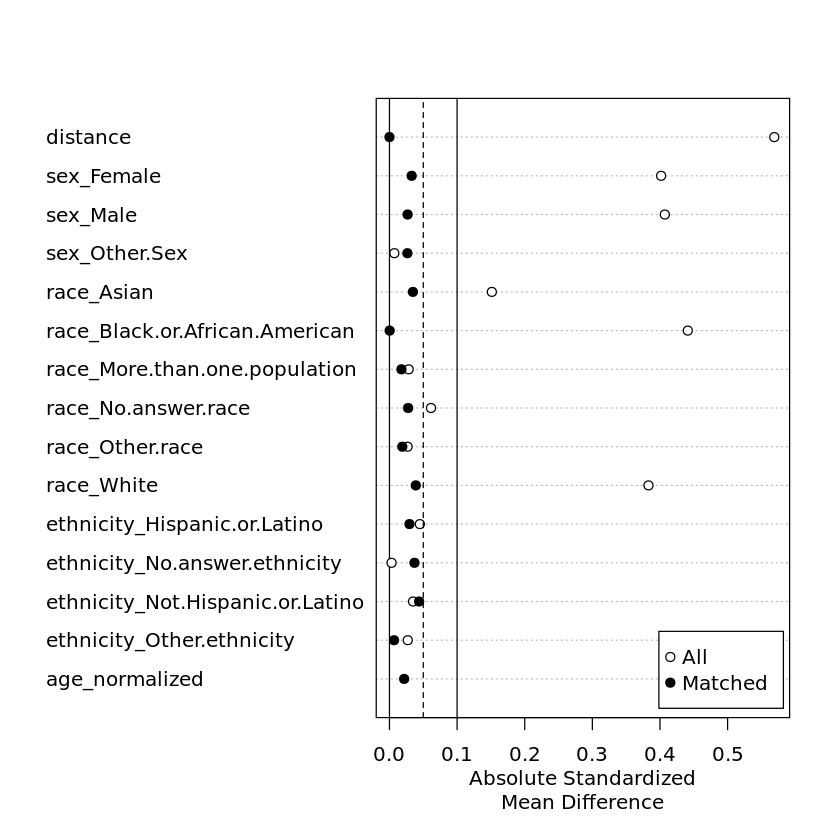

In [49]:
plot(summary(m.out0, pair.dist = FALSE))

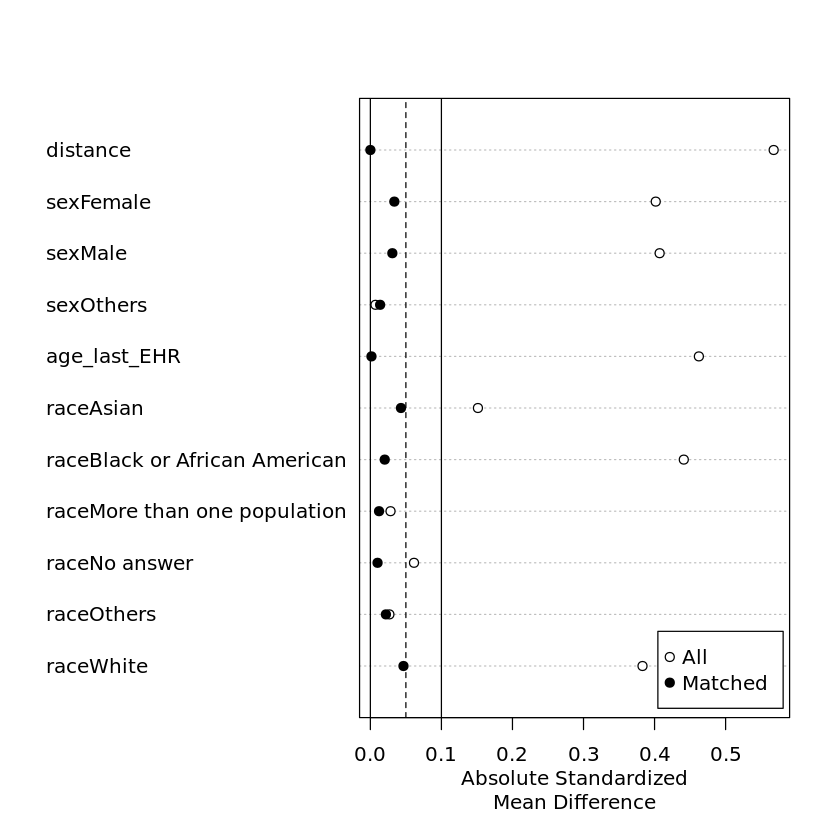

In [82]:
plot(summary(m.out0, pair.dist = FALSE))

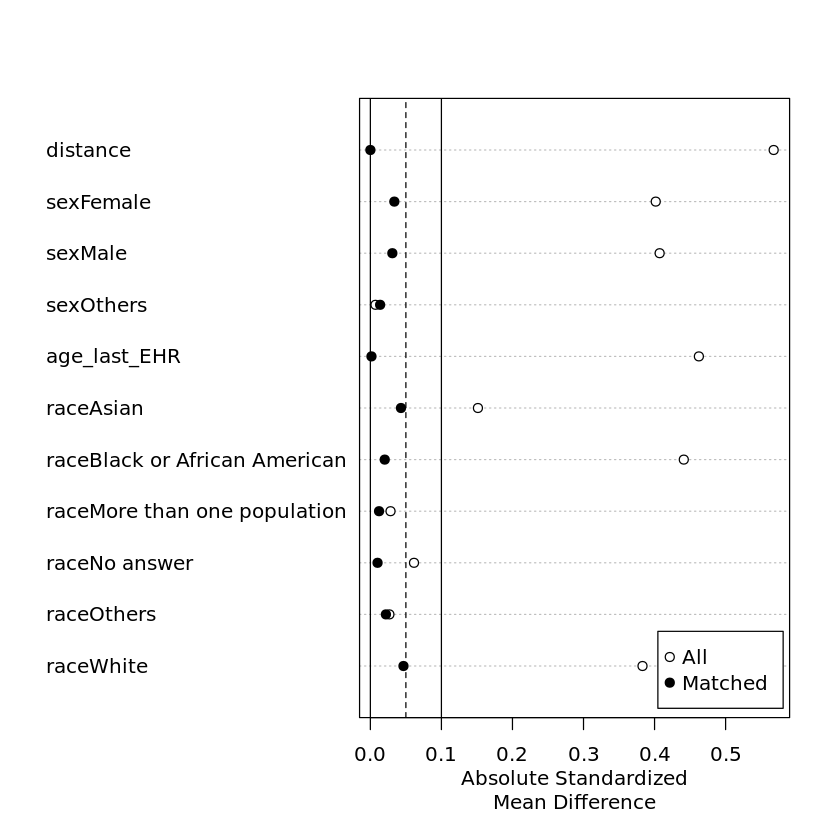

In [83]:
plot(summary(m.out1, pair.dist = FALSE))

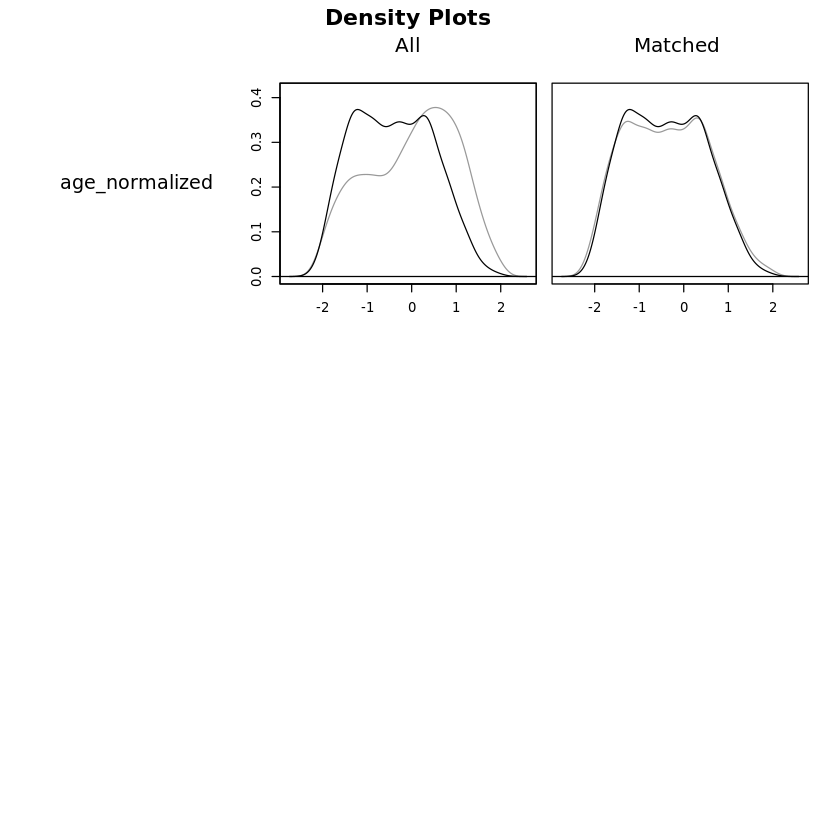

In [55]:
# plot(m.out0, type = "density", interactive = FALSE,
#      which.xs = ~age_normalized + race + sex)
# Generate density plot for age_normalized
plot(m.out0, type = "density", which.xs = ~age_normalized)

# Generate bar plots for each dummy variable
dummy_vars <- c("sex_Female", "sex_Male", "sex_Other.Sex",
                "race_Asian", "race_Black.or.African.American",
                "race_More.than.one.population", "race_No.answer.race",
                "race_Other.race", "race_White",
                "ethnicity_Hispanic.or.Latino", "ethnicity_No.answer.ethnicity",
                "ethnicity_Not.Hispanic.or.Latino", "ethnicity_Other.ethnicity")

# for (var in dummy_vars) {
#   plot(m.out0, type = "density", which.xs = as.formula(paste("~", var)))
# }
for (var in dummy_vars) {
  png(paste0("matchit_plot_", var, ".png"), width = 800, height = 600)
  plot(m.out0, type = "density", which.xs = as.formula(paste("~", var)))
  dev.off()
}

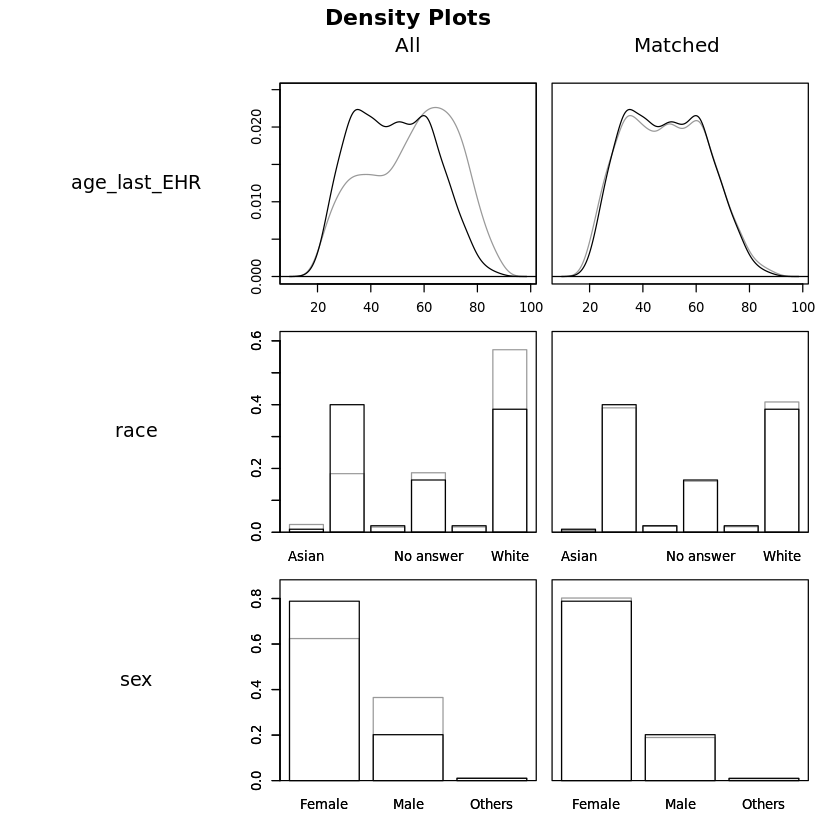

In [72]:
plot(m.out1, type = "density", interactive = FALSE,
     which.xs = ~age_last_EHR + race + sex)

### Retrieve data

In [56]:
m.data <- match.data(m.out0,distance='pscore')
# Get the person_ids of the matched observations
matched_person_ids <- m.data$person_id

# Write the matched_person_ids to a CSV file
write.csv(matched_person_ids, "matched_person_ids.csv", row.names = FALSE)

### Match control for HS female

In [31]:
df_f=subset(df_sub_1,sex_Female== 1)

In [32]:
head(df_f)

,person_id,sex_at_birth,HS,age_last_EHR,age_normalized,sex_Female,sex_Male,sex_Other.Sex,race_Asian,race_Black.or.African.American,race_More.than.one.population,race_No.answer.race,race_Other.race,race_White,ethnicity_Hispanic.or.Latino,ethnicity_No.answer.ethnicity,ethnicity_Not.Hispanic.or.Latino,ethnicity_Other.ethnicity
,<int>,<chr>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,7189522,Female,0,66.06849,0.6423234,1,0,0,0,0,0,0,0,1,0,0,1,0
2,9306478,Female,0,64.50137,0.5485422,1,0,0,0,0,0,0,0,1,0,0,1,0
6,3161593,Female,0,57.76438,0.1453815,1,0,0,0,0,0,0,0,1,0,0,1,0
9,1706475,Female,0,66.98630,0.6972477,1,0,0,0,1,0,0,0,0,0,0,1,0
10,2395521,Female,0,49.05479,-0.3758254,1,0,0,0,0,0,0,0,1,0,0,1,0
11,2563639,Female,0,36.98904,-1.0978748,1,0,0,0,1,0,0,0,0,0,0,1,0


In [33]:
# m.outf <- matchit(HS ~  age_last_EHR + race ,
#                   data = df_f,
#                   method = "nearest", 
#                   ratio = 10)

m.outf <- matchit(HS ~ 
                    race_Asian + race_Black.or.African.American + 
                    race_More.than.one.population + race_No.answer.race + 
                    race_Other.race + race_White +
                    ethnicity_Hispanic.or.Latino + ethnicity_No.answer.ethnicity +
                    ethnicity_Not.Hispanic.or.Latino + ethnicity_Other.ethnicity +
                    age_normalized,
                  data = df_f,
                  method = "nearest", 
                  ratio = 10)


In [34]:
summary(m.outf)


Call:
matchit(formula = HS ~ race_Asian + race_Black.or.African.American + 
    race_More.than.one.population + race_No.answer.race + race_Other.race + 
    race_White + ethnicity_Hispanic.or.Latino + ethnicity_No.answer.ethnicity + 
    ethnicity_Not.Hispanic.or.Latino + ethnicity_Other.ethnicity + 
    age_normalized, data = df_f, method = "nearest", ratio = 10)

Summary of Balance for All Data:
                                 Means Treated Means Control Std. Mean Diff.
distance                                0.0185        0.0126          0.5214
race_Asian                              0.0081        0.0248         -0.1865
race_Black.or.African.American          0.3972        0.1848          0.4342
race_More.than.one.population           0.0220        0.0182          0.0257
race_No.answer.race                     0.1668        0.1965         -0.0798
race_Other.race                         0.0208        0.0156          0.0364
race_White                              0.3851        0.560

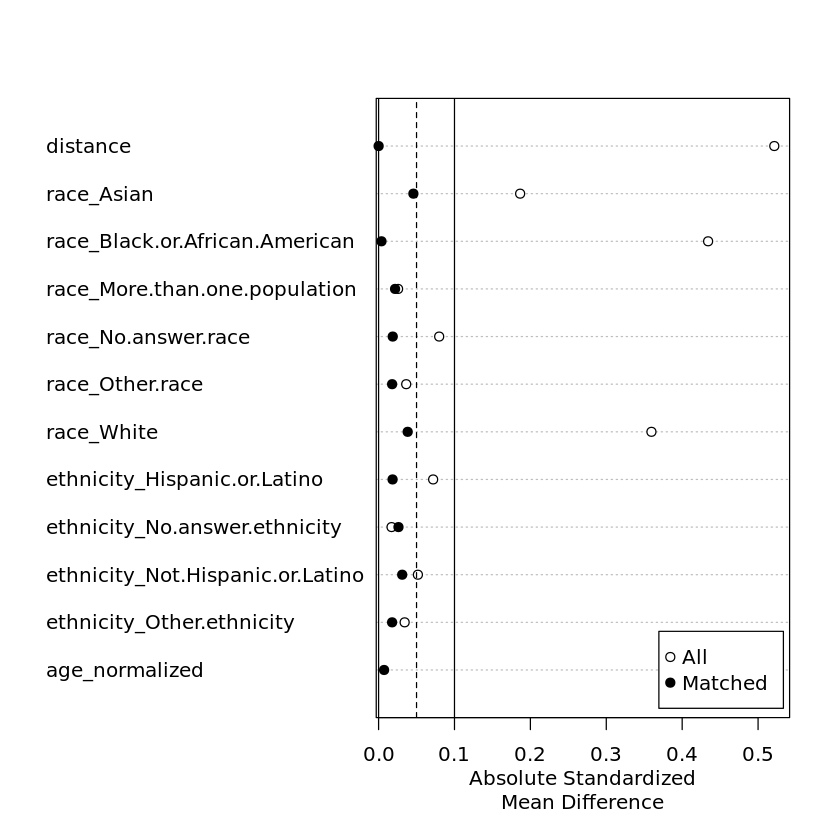

In [35]:
plot(summary(m.outf, pair.dist = FALSE))

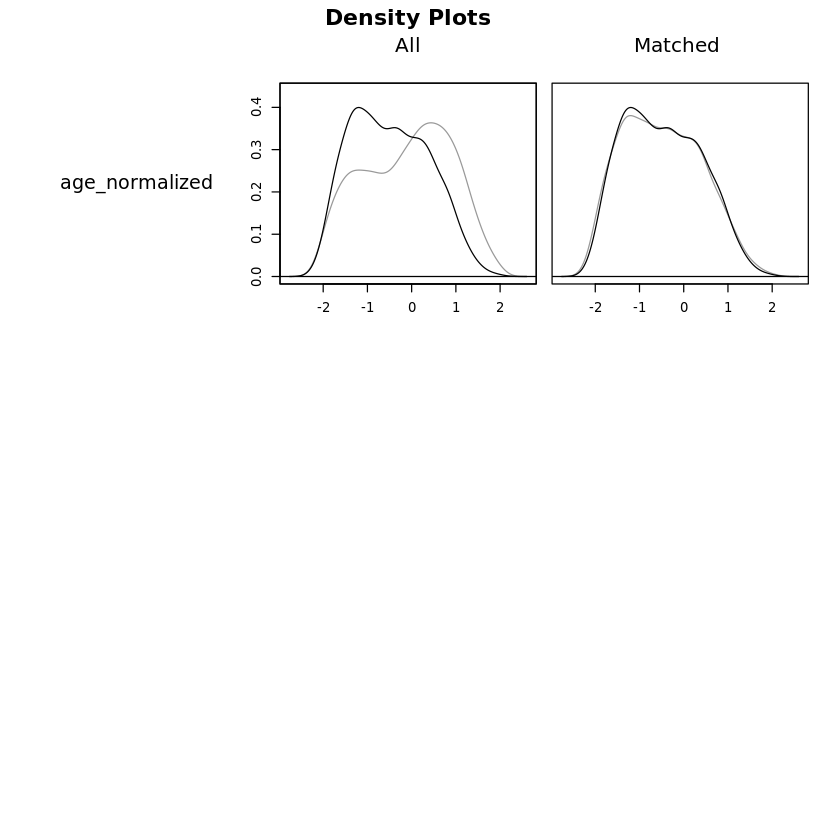

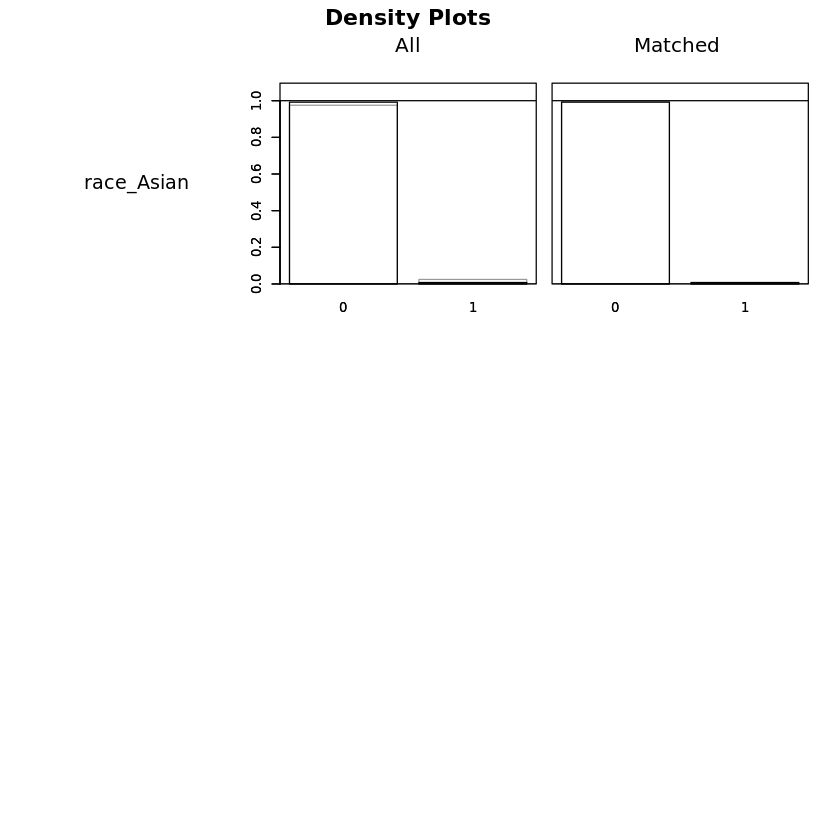

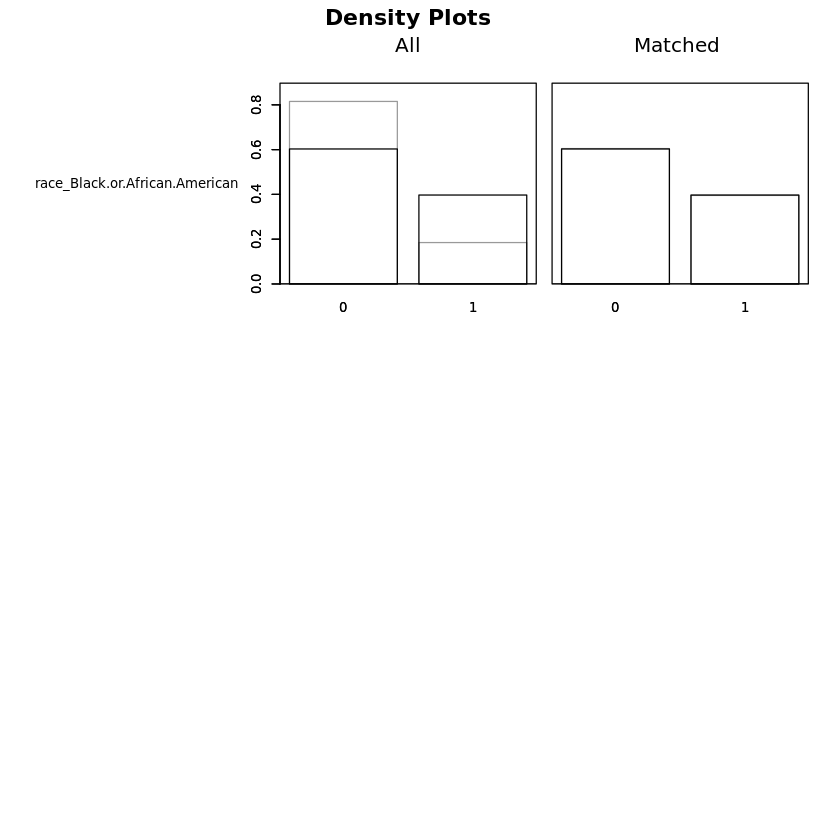

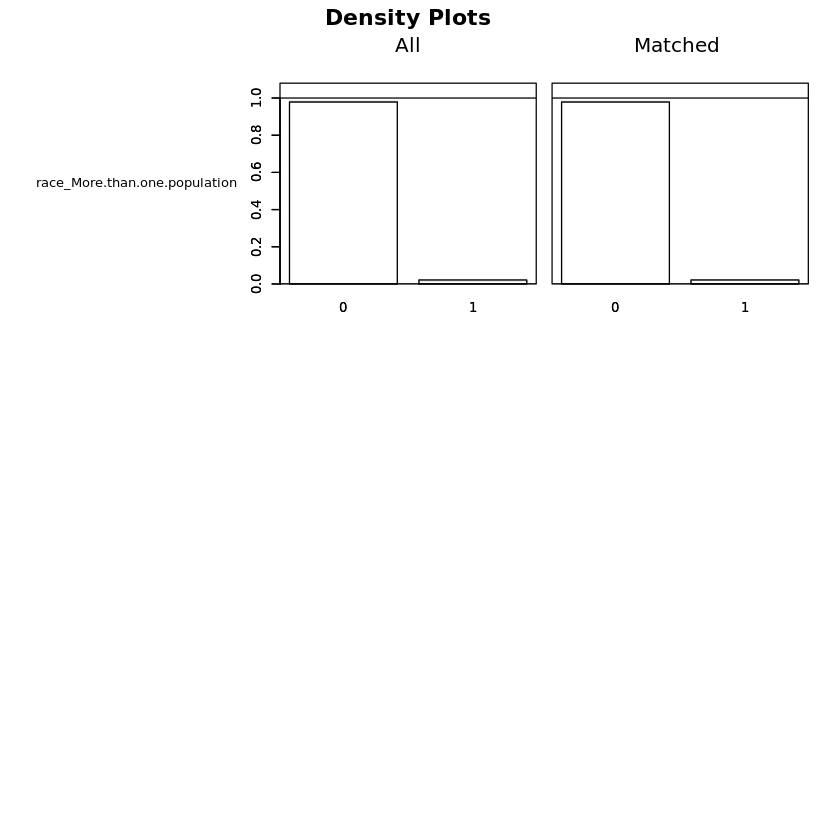

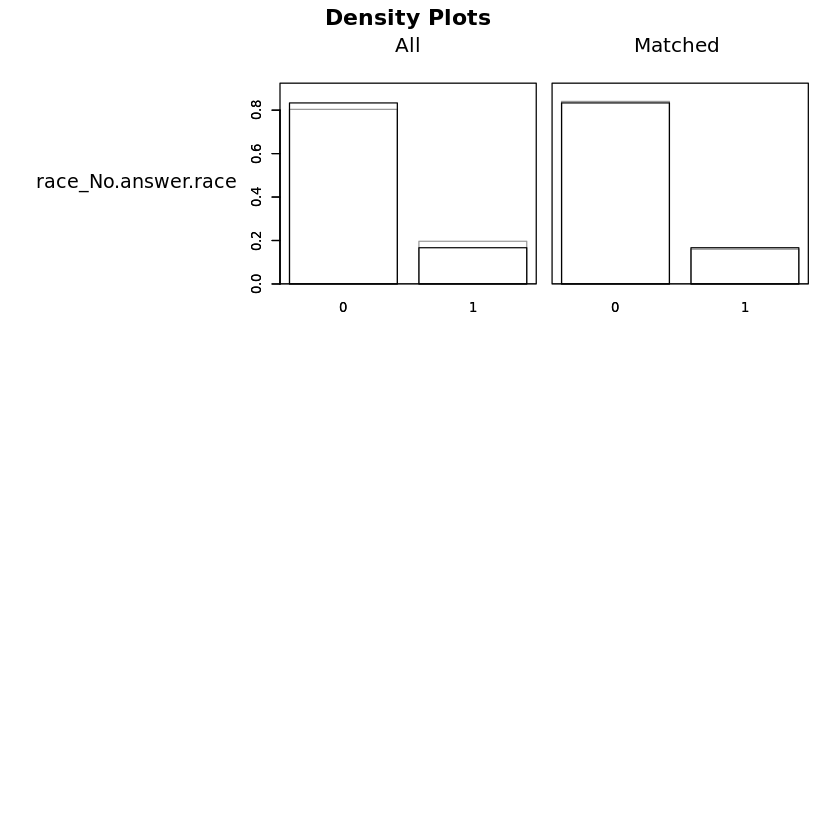

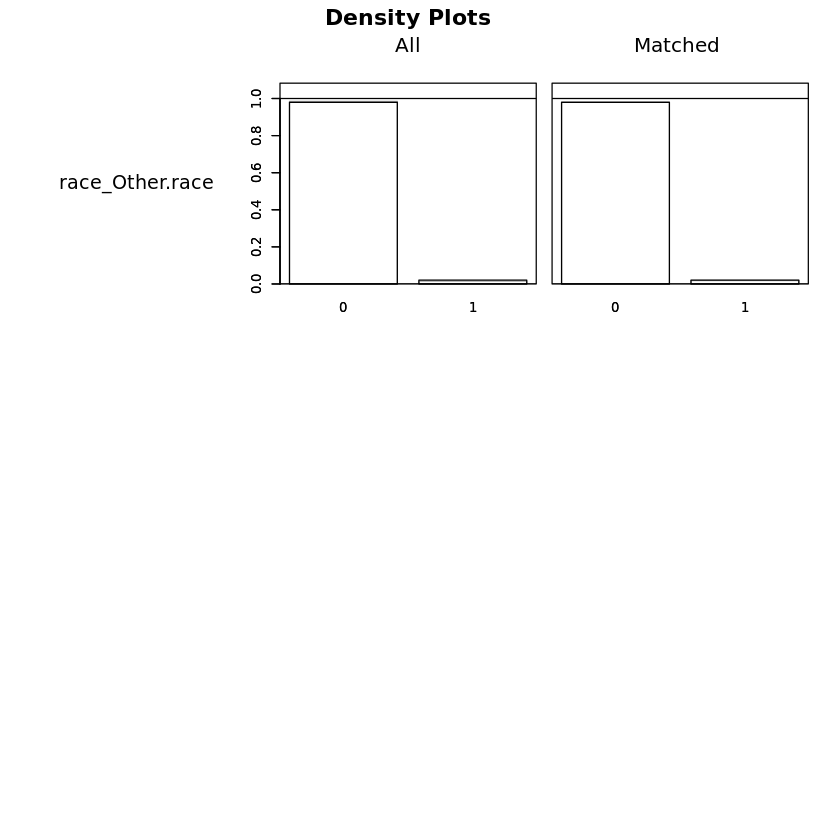

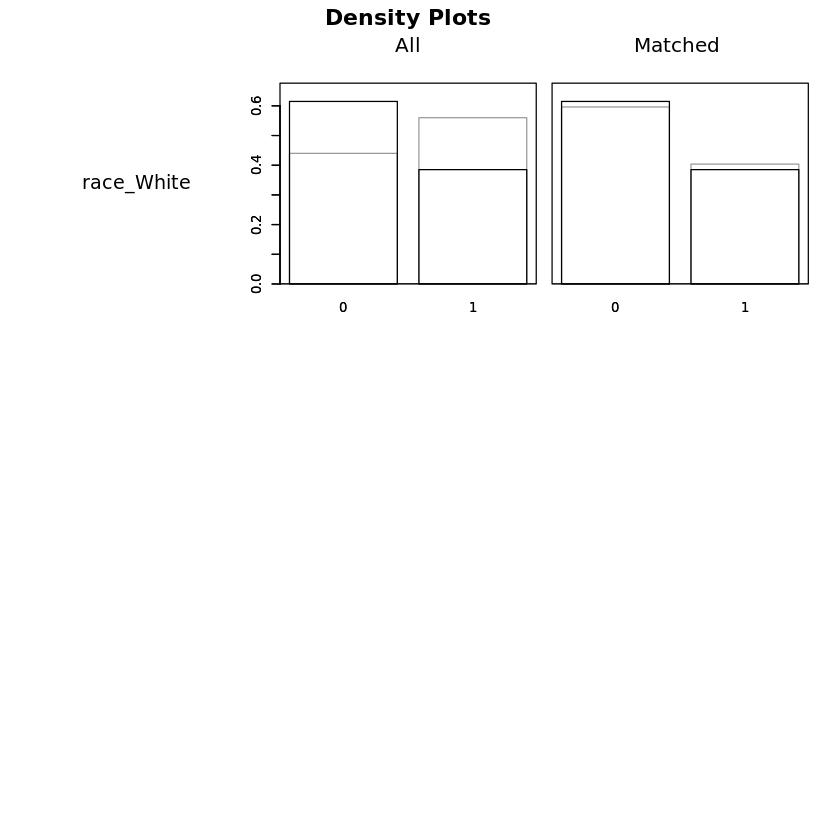

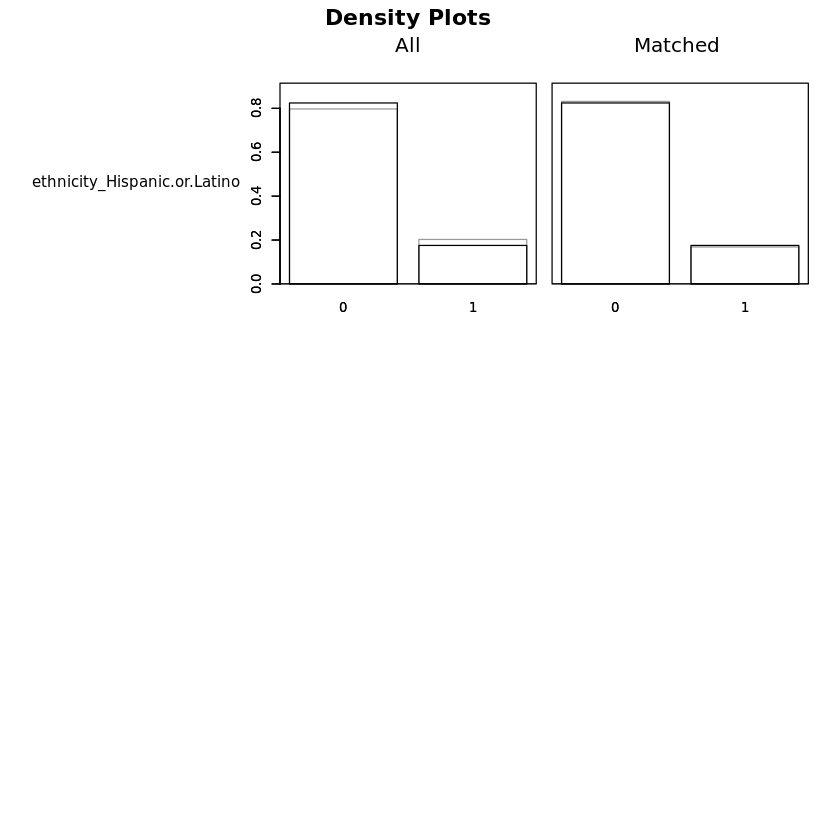

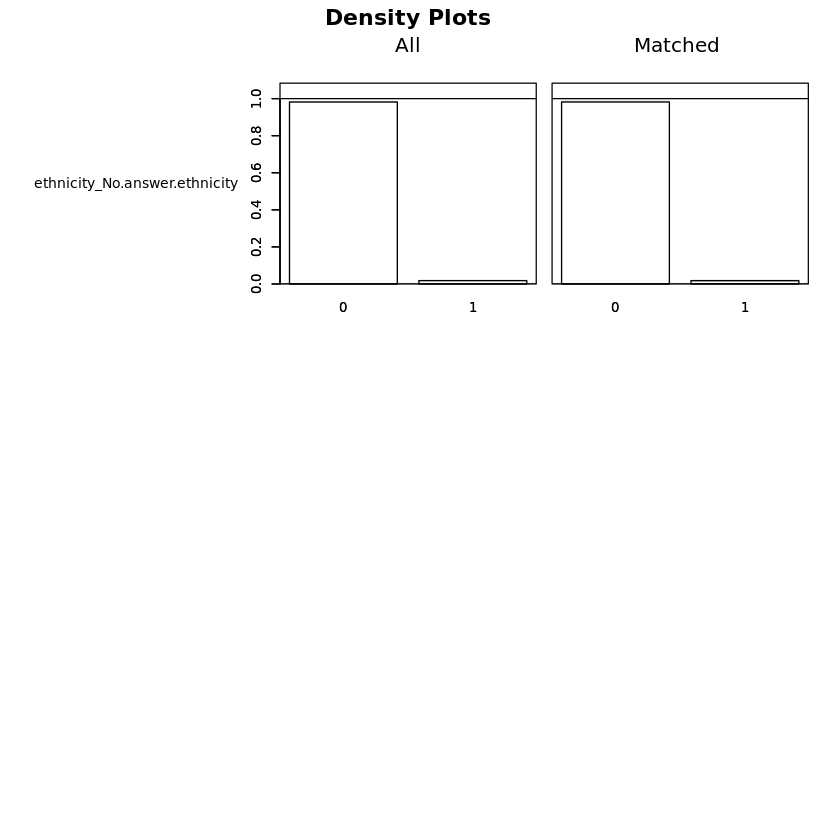

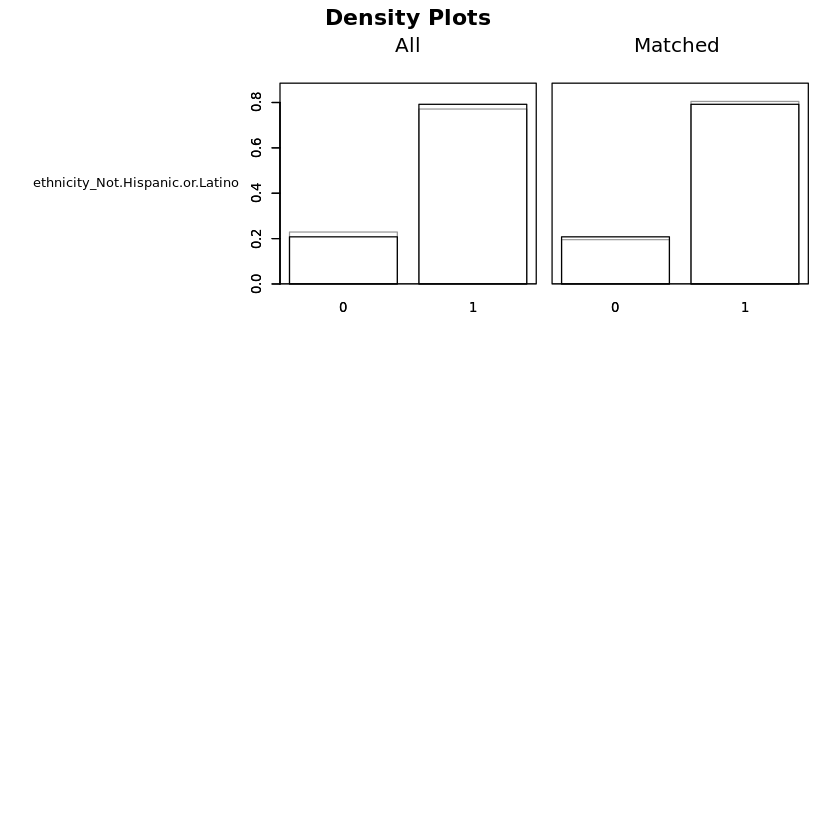

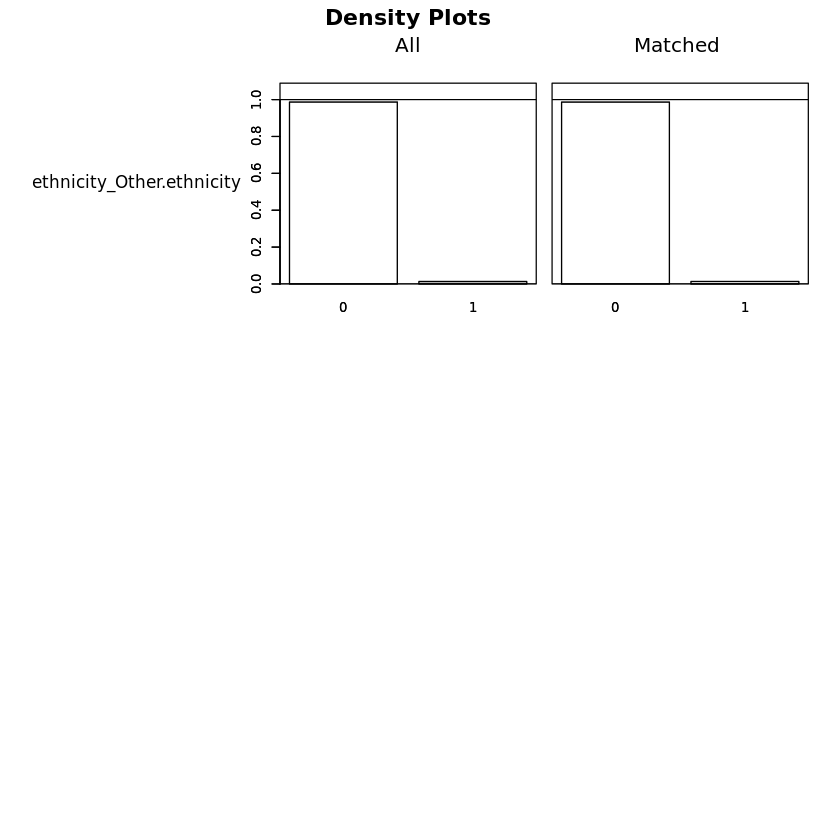

In [39]:
plot(m.outf, type = "density", which.xs = ~age_normalized)

# Generate bar plots for each dummy variable
dummy_vars <- c(
                "race_Asian", "race_Black.or.African.American",
                "race_More.than.one.population", "race_No.answer.race",
                "race_Other.race", "race_White",
                "ethnicity_Hispanic.or.Latino", "ethnicity_No.answer.ethnicity",
                "ethnicity_Not.Hispanic.or.Latino", "ethnicity_Other.ethnicity")

for (var in dummy_vars) {
  plot(m.outf, type = "density", which.xs = as.formula(paste("~", var)))
}
# for (var in dummy_vars) {
#   png(paste0("matchit_plot_f", var, ".png"), width = 800, height = 600)
#   plot(m.outf, type = "density", which.xs = as.formula(paste("~", var)))
#   dev.off()
# }

In [40]:
m.data <- match.data(m.outf,distance='pscore')
# Get the person_ids of the matched observations
matched_person_ids <- m.data$person_id

# Write the matched_person_ids to a CSV file
write.csv(matched_person_ids, "matched_person_ids_female.csv", row.names = FALSE)

### Match control for HS male

In [41]:
df_m=subset(df_sub_1,sex_Male== 1)

In [42]:
head(df_m)

,person_id,sex_at_birth,HS,age_last_EHR,age_normalized,sex_Female,sex_Male,sex_Other.Sex,race_Asian,race_Black.or.African.American,race_More.than.one.population,race_No.answer.race,race_Other.race,race_White,ethnicity_Hispanic.or.Latino,ethnicity_No.answer.ethnicity,ethnicity_Not.Hispanic.or.Latino,ethnicity_Other.ethnicity
,<int>,<chr>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
3,9557736,Male,0,55.07945,-0.01529251,0,1,0,0,0,0,0,0,1,0,0,1,0
4,1840872,Male,0,60.06575,0.28310213,0,1,0,0,0,0,0,0,1,0,0,1,0
5,3486599,Male,0,86.10137,1.84114842,0,1,0,0,0,0,0,0,1,0,0,1,0
7,1328970,Male,0,64.96164,0.57608631,0,1,0,0,1,0,0,0,0,0,0,1,0
8,4906905,Male,0,59.98904,0.27851144,0,1,0,0,0,0,0,0,1,0,0,1,0
12,1739054,Male,0,66.01918,0.63937221,0,1,0,0,0,0,0,0,1,0,0,1,0


In [43]:
# m.outm <- matchit(HS ~  age_last_EHR + race ,
#                   data = df_m,
#                   method = "nearest", 
#                   ratio = 10)
m.outm <- matchit(HS ~ 
                    race_Asian + race_Black.or.African.American + 
                    race_More.than.one.population + race_No.answer.race + 
                    race_Other.race + race_White +
                    ethnicity_Hispanic.or.Latino + ethnicity_No.answer.ethnicity +
                    ethnicity_Not.Hispanic.or.Latino + ethnicity_Other.ethnicity +
                    age_normalized,
                  data = df_m,
                  method = "nearest", 
                  ratio = 10)


In [44]:
summary(m.outm)


Call:
matchit(formula = HS ~ race_Asian + race_Black.or.African.American + 
    race_More.than.one.population + race_No.answer.race + race_Other.race + 
    race_White + ethnicity_Hispanic.or.Latino + ethnicity_No.answer.ethnicity + 
    ethnicity_Not.Hispanic.or.Latino + ethnicity_Other.ethnicity + 
    age_normalized, data = df_m, method = "nearest", ratio = 10)

Summary of Balance for All Data:
                                 Means Treated Means Control Std. Mean Diff.
distance                                0.0078        0.0056          0.5139
race_Asian                              0.0158        0.0241         -0.0664
race_Black.or.African.American          0.4208        0.1863          0.4750
race_More.than.one.population           0.0158        0.0139          0.0152
race_No.answer.race                     0.1244        0.1485         -0.0729
race_Other.race                         0.0204        0.0189          0.0103
race_White                              0.4027        0.608

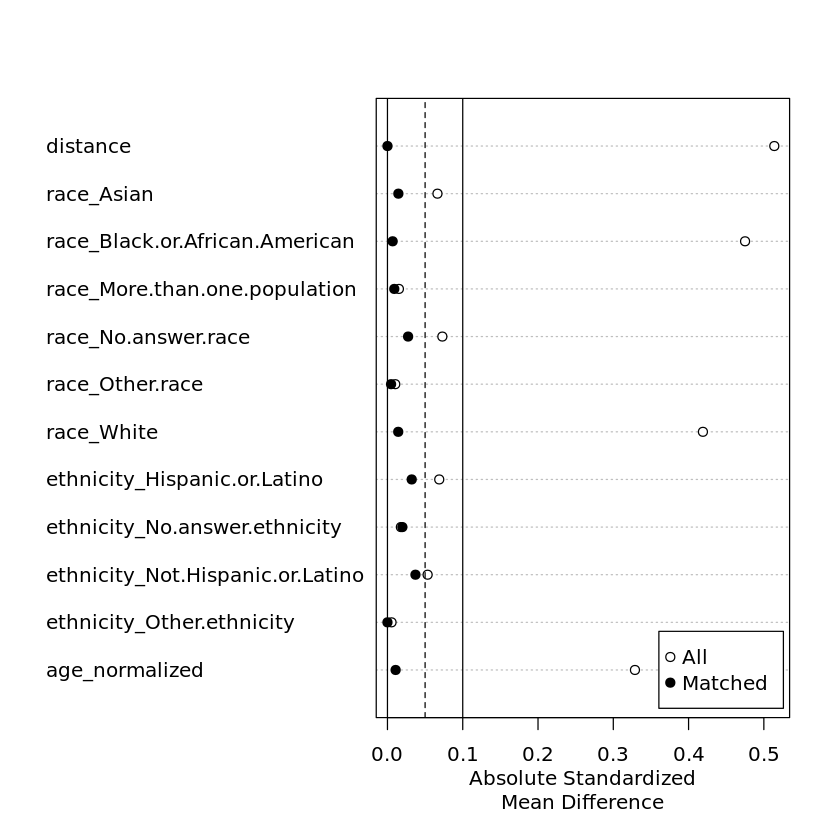

In [46]:
plot(summary(m.outm, pair.dist = FALSE))

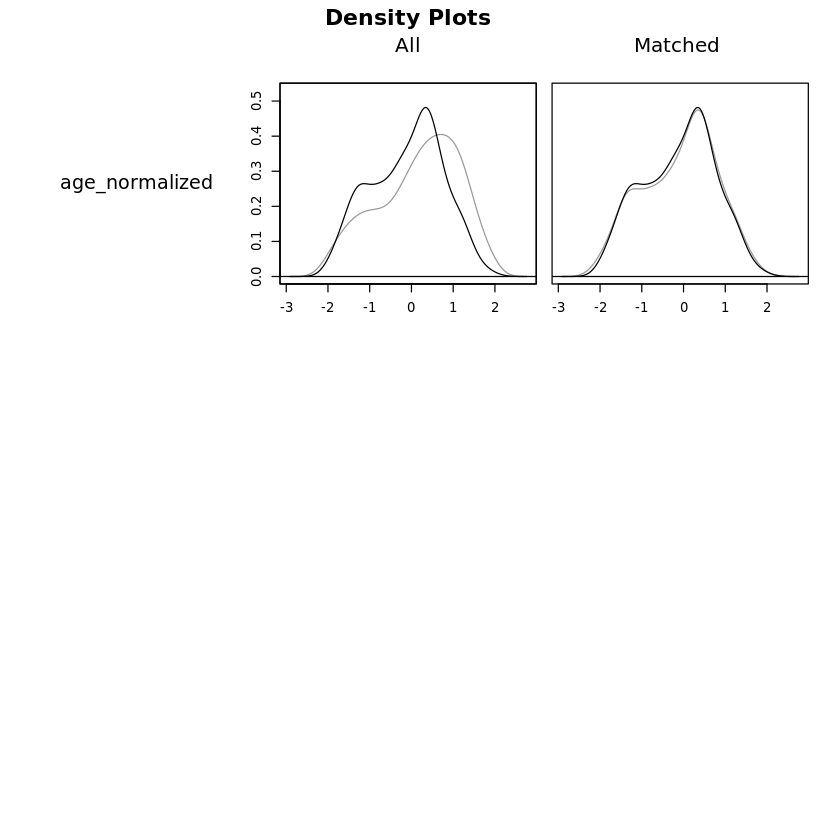

In [48]:
plot(m.outm, type = "density", which.xs = ~age_normalized)

# Generate bar plots for each dummy variable
dummy_vars <- c(
                "race_Asian", "race_Black.or.African.American",
                "race_More.than.one.population", "race_No.answer.race",
                "race_Other.race", "race_White",
                "ethnicity_Hispanic.or.Latino", "ethnicity_No.answer.ethnicity",
                "ethnicity_Not.Hispanic.or.Latino", "ethnicity_Other.ethnicity")

# for (var in dummy_vars) {
#   plot(m.outm, type = "density", which.xs = as.formula(paste("~", var)))
# }
for (var in dummy_vars) {
  png(paste0("matchit_plot_m", var, ".png"), width = 800, height = 600)
  plot(m.outm, type = "density", which.xs = as.formula(paste("~", var)))
  dev.off()
}

In [45]:
m.datam <- match.data(m.outm,distance='pscore')
# Get the person_ids of the matched observations
matched_person_ids_male <- m.datam$person_id

# Write the matched_person_ids to a CSV file
write.csv(matched_person_ids_male, "matched_person_ids_male.csv", row.names = FALSE)

### Plot

In [53]:
pdf("love_plot.pdf", width = 8, height = 6) 
plot(summary(m.out0, pair.dist = FALSE))
dev.off()

png 
  2

In [54]:
# pdf("density_plot.pdf", width = 8, height = 6) 

# plot(m.out0, type = "density", interactive = FALSE,
#      which.xs = ~age_last_EHR + race )

# dev.off()
png("matchit_density_plot.png", width = 800, height = 600)
plot(m.out0, type = "density", which.xs = ~age_normalized)
dev.off()


png 
  2

In [31]:
# 提取 PSM 後的數據
age_density <- density(m.out0$age_last_EHR)
race_density <- density(m.out0$race)

# 繪製年齡的密度圖，並指定顏色
plot(age_density, col = "blue", main = "Density Plot of Age and Race", xlab = "Values", ylab = "Density")

# 疊加種族的密度圖，並指定顏色
lines(race_density, col = "green")


ERROR: Error in density.default(m.out0$age_last_EHR): argument 'x' must be numeric
